# Y-Position Phase Analysis: Pillar Displacement Study

## Overview
This notebook investigates the phase interactions between adjacent cells in the photonic structure. By systematically displacing a single pillar (pillar 31) along the y-axis, this analysis maps how a local change affects the phase of the accelerating field (`e1`) in all other cells.

## Key Objectives
- **Sensitivity Analysis**: To understand how the y-position of a single pillar influences the phase response of the entire 61-period structure.
- **Feature Space Mapping**: To characterize the coupling and cross-talk between cells. The resulting heatmap visualizes the extent of these interactions.
- **Envelope Fitting**: To model the decay of the phase interaction, a Gaussian and an inverse square envelope are fitted to the data, providing a quantitative measure of the coupling length.

### Methodology
- A 61-period structure is simulated using the adjoint method.
- Pillar 31 is incrementally displaced along the y-axis over 22 steps.
- At each step, a full FDTD simulation is run to compute the `e1` phase in every cell.
- The results are compiled into a heatmap, showing the phase of each cell (x-axis) for each y-position of pillar 31 (y-axis).
- The maximum phase change is plotted and fitted to different physical models.

### Key Functions
- `func()`: Runs the FDTD simulation for a given set of pillar parameters.
- `adjoint_source_calc()`: Calculates the phase distribution for the adjoint source.
- `sns.heatmap()`: Generates the phase interaction heatmap.
- `curve_fit()`: Fits Gaussian and inverse square models to the phase change data.

### Results
- A heatmap visualizing the phase sensitivity across all cells due to a single pillar's displacement.
- A quantitative analysis of the interaction length, showing a full-width at half-maximum (FWHM) of approximately 7 µm.

## Usage
The main loop iterates through different y-positions for the central pillar, running simulations and saving the output. The final cells load this data and generate the heatmap and envelope-fitting plots.

In [ ]:
import sys, os
sys.path.append("C:\\Program Files\\Lumerical\\v221\\api\\python\\") #Default windows lumapi path
import numpy as np
import matplotlib.pyplot as plt
import lumapi
from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.optimize as so
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from numpy import unravel_index
from numpy import linalg as npla
from scipy.optimize import basinhopping
import random
from IPython.core.debugger import set_trace
import math
import time
import cmath
from scipy import interpolate
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit 
import pandas as pd 
import scipy.special as sp
from matplotlib import pylab
from pylab import figure, text, scatter, show
from scipy import stats
from pylab import *
import scipy.interpolate
from scipy.signal import argrelextrema
from scipy.spatial import distance
import seaborn as sns

In [12]:
lml = 1.932e-6 #laser wavelength
beta = 0.3 #electron velocity 
Periods = 61

x_adj_arr = 0.0
z_adj_arr = 1.5e-6                            
lambda0 = lml
c = 3e8 #speed of light 
f = c/lambda0 #frequency
q = 1 #charge in e
m = 0.511e6 #mass in eV/c**2
Ey = 1 

beta_array = np.full((Periods,), beta) #array of electron velocity at each period
Periods_array = lml*beta_array #periodicity of each cell
preperarr = Periods_array.copy()
delta_W = np.zeros((Periods,1))
EyFmax_forward = np.ones((Periods), dtype=complex)
prev_G = np.full((Periods,1), 100.0)

'''
#exponential design curve
a = np.linspace(np.log(20), np.log(80), Periods)
z = np.exp(a)
d_n = np.reshape(z,(Periods,1)) 
'''

a = np.linspace(0,2*np.pi,Periods)
z = (np.cos(3*a))/45 + np.cos(a)/45 + np.cos(5*a)/50 + np.cos(2*a)/40 + 0.05
d_n = z.copy()

#2*(a/(2*np.pi) - (1/2 + a/(2*np.pi)))




max_Periods_array = Periods_array.copy()

#variable declarations
Adjoint_phase = 0.0
lockin = 0 #optimizes the structure from begining to end, 'locking in' the values below a tolerance
lockin_prev = 0
x0point = 0
tol = 0.06 #tolerance parameter for the optimizer, difference of e1 and d_n for ~3 periods
e = []
rarr = []
ephi = []
lmp = lml*beta #synchronicity condition for m=1
i = 0 #used for numbering files
number_of_params = 3

d_n

array([0.13944444, 0.13500927, 0.12255341, 0.10442191, 0.08389632,
       0.0644245 , 0.04883654, 0.03874514, 0.0342782 , 0.03420188,
       0.03638889, 0.03849625, 0.03866346, 0.03604024, 0.03100212,
       0.025     , 0.0200905 , 0.01828249, 0.02088569, 0.02804722,
       0.03861111, 0.05034727, 0.06049537, 0.06648128, 0.06661431,
       0.0605755 , 0.04956021, 0.03602894, 0.02312387, 0.01389811,
       0.01055556, 0.01389811, 0.02312387, 0.03602894, 0.04956021,
       0.0605755 , 0.06661431, 0.06648128, 0.06049537, 0.05034727,
       0.03861111, 0.02804722, 0.02088569, 0.01828249, 0.0200905 ,
       0.025     , 0.03100212, 0.03604024, 0.03866346, 0.03849625,
       0.03638889, 0.03420188, 0.0342782 , 0.03874514, 0.04883654,
       0.0644245 , 0.08389632, 0.10442191, 0.12255341, 0.13500927,
       0.13944444])

In [13]:
def e1_scaling_sigmoid(desired_beta):
    energy_scaling = 0.1681616 + 0.71904549/(1+np.exp(-15.87927686*(desired_beta-0.48068445)))
    return energy_scaling *0.75

Barray = np.sqrt((2*d_n)/m)
d_n = e1_scaling_sigmoid(Barray)

In [14]:
d_n

array([0.1263853 , 0.12638525, 0.1263851 , 0.12638488, 0.1263846 ,
       0.12638431, 0.12638404, 0.12638384, 0.12638374, 0.12638374,
       0.12638379, 0.12638383, 0.12638384, 0.12638378, 0.12638367,
       0.12638352, 0.12638338, 0.12638333, 0.12638341, 0.12638359,
       0.12638383, 0.12638406, 0.12638424, 0.12638434, 0.12638434,
       0.12638424, 0.12638405, 0.12638378, 0.12638347, 0.12638319,
       0.12638306, 0.12638319, 0.12638347, 0.12638378, 0.12638405,
       0.12638424, 0.12638434, 0.12638434, 0.12638424, 0.12638406,
       0.12638383, 0.12638359, 0.12638341, 0.12638333, 0.12638338,
       0.12638352, 0.12638367, 0.12638378, 0.12638384, 0.12638383,
       0.12638379, 0.12638374, 0.12638374, 0.12638384, 0.12638404,
       0.12638431, 0.1263846 , 0.12638488, 0.1263851 , 0.12638525,
       0.1263853 ])

In [15]:
W_array = np.full(Periods, m/2*beta**2) #injection energy

def accel_calc(period, EY):
    '''

    Takes in a periodicity array and array of e1 values and calculates energy and velocity and then 
    returns an updated periodicity array.  
    
    '''
    global delta_W
    global beta_array
    global W_array
    for j in range(Periods-1):
        #energy calculation from 6D tracking eq 7
        delta_W[j] = q*period[j]*np.real(EY[j]*np.exp(2*np.pi*1j*period[j]/max_Periods_array[j]))*100e6 #possibly need to add a phase term here   
        W_array[j+1] = W_array[j] + delta_W[j]
        #beta calculated from energy
        beta_array[j+1] =  np.sqrt((2*W_array[j+1])/m)
        period[j+1] = lml*beta_array[j+1]
    #update the last element of the array
    delta_W[-1] = q*period[-1]*np.real(EY[-1]*np.exp(2*np.pi*1j*period[-1]/max_Periods_array[-1]))*100e6
    return period

In [16]:
#max_Periods_array = accel_calc(max_Periods_array, d_n.flatten()) #calculate the max_Periods from the design curve
FDTDxspan = 4.2e-6
FDTDyspan = np.sum(max_Periods_array)
FDTDdx = 10.0e-9
FDTDdy = 10.0e-9
yarrsize = math.ceil(max_Periods_array[-1]/FDTDdy) #max array size to interpolate all cells to, for numpy array operations
xarrsize = math.ceil(FDTDxspan/(2*FDTDdx)) + 1
cell_size = yarrsize//Periods
Xmax = np.linspace(0.0, FDTDxspan/2, xarrsize)
Ymax = np.linspace(0.0, FDTDyspan, yarrsize)
max_Periods_array[0]*30

1.7387999999999997e-05

In [17]:
W_array[-1]/W_array[0]

1.0

In [18]:
rguess1 = None
rguess1 = np.full((Periods, number_of_params), [110e-9, 170e-9, lmp/2])
for j in range(Periods):
    rguess1[j][2] =  (0.5*max_Periods_array[j])+np.sum(max_Periods_array[:j])
#rguess1 = np.append(rguess1,np.reshape(Periods_array.copy(), (Periods,1)),axis=1)
#rguess1 = rguess1.flatten()
rguess1

array([[1.10000e-07, 1.70000e-07, 2.89800e-07],
       [1.10000e-07, 1.70000e-07, 8.69400e-07],
       [1.10000e-07, 1.70000e-07, 1.44900e-06],
       [1.10000e-07, 1.70000e-07, 2.02860e-06],
       [1.10000e-07, 1.70000e-07, 2.60820e-06],
       [1.10000e-07, 1.70000e-07, 3.18780e-06],
       [1.10000e-07, 1.70000e-07, 3.76740e-06],
       [1.10000e-07, 1.70000e-07, 4.34700e-06],
       [1.10000e-07, 1.70000e-07, 4.92660e-06],
       [1.10000e-07, 1.70000e-07, 5.50620e-06],
       [1.10000e-07, 1.70000e-07, 6.08580e-06],
       [1.10000e-07, 1.70000e-07, 6.66540e-06],
       [1.10000e-07, 1.70000e-07, 7.24500e-06],
       [1.10000e-07, 1.70000e-07, 7.82460e-06],
       [1.10000e-07, 1.70000e-07, 8.40420e-06],
       [1.10000e-07, 1.70000e-07, 8.98380e-06],
       [1.10000e-07, 1.70000e-07, 9.56340e-06],
       [1.10000e-07, 1.70000e-07, 1.01430e-05],
       [1.10000e-07, 1.70000e-07, 1.07226e-05],
       [1.10000e-07, 1.70000e-07, 1.13022e-05],
       [1.10000e-07, 1.70000e-07, 1.1881

In [19]:
def adjoint_source_calc(periods):
    
    '''
    This function calculates the phase of the adjoint source for each cell's given periodicity. 
    It makes an Ey array and 2 y arrays. The purpose of the two y-arrays is one is used to calculate 
    the phase of Ey (using the cell's periodicity), while the second is returned as the y position 
    array for the adjoint source in lumerical. Conceptually it creates multiple sinusoids of increasing
    frequency (for the increasing period size) and then concatenates them. 
    
    It takes in a periodicity array and returns Ey and the concatenated y array. 
    '''

    Ey_n = np.zeros((Periods,yarrsize), dtype='complex')
    y_adj_arr = np.zeros((Periods,yarrsize))
    y_adj_arr2 = np.zeros((Periods,yarrsize))
    y_adj_arr[0] = np.linspace(0.0, periods[0], yarrsize)
    y_adj_arr2[0] = np.linspace(0.0, periods[0], yarrsize)
    
    for j in range(1,Periods):
        y_adj_arr[j] = np.linspace(j*periods[j], (j+1)*periods[j], yarrsize) #array for the cell size for the phase calculation 
        y_adj_arr2[j] = np.linspace(np.sum(periods[:j]), np.sum(periods[:j+1]), yarrsize)  #array for the ypos of the Ey points
        
    for j in range(Periods):
        Ey_n[j] = 1j*np.exp(1j*2*np.pi*(y_adj_arr[j]+periods[j]/2)/periods[j]) #Ey phase calculation
        
        
    Ey = np.ravel(Ey_n) #flattens the arrays before returning
    y_adj_arr = np.ravel(y_adj_arr2)
    
    return Ey, y_adj_arr

In [20]:
Ey, y_adj_arr = adjoint_source_calc(max_Periods_array)

In [21]:
def open_lumerical():
    ''' 
    
    This function opens lumerical via lumapi and sets up an FDTD simulation area.
    
    '''
    
    global fdtd 
    fdtd = lumapi.FDTD()
    
    fdtd.addfdtd()
    fdtd.redrawoff() #just turns the animation off to save simulation time
    #self explanatory settings
    configuration = (
        
        ("FDTD", (("dimension", "2D"), 
                    ("y", FDTDyspan/2), 
                    ("y span", (FDTDyspan)), #extend the FDTD region 3 wavelengths in each direction 
                                                    #to elminate 'ringing' from TFSF source
                    ("x", 0.0), 
                    ("x span", FDTDxspan), 
                    ("z", 1.5e-6), 
                    ("simulation time", 130e-15), 
                    ("mesh type", "uniform"),
                    ("dx", FDTDdx), 
                    ("dy", FDTDdy), 
                    ("y min bc", "Periodic"), 
                    ("y max bc", "Periodic"),
                    ("x min bc", "Symmetric") 
                    )),
                
        
        
    )
    for obj, parameters in configuration:
        for k, v in parameters:
            fdtd.setnamed(obj, k, v)
            
            
    return 

In [22]:
def monitors_func(r):
    '''
    
    This function sets up the field and index monitors for each simulation, taking in the periodicity array as a variable.
    
    '''
    period = r.copy()
    for x in range(Periods):
        fdtd.addindex()
        fdtd.set("name", "index_monitor-{}".format(x))
        fdtd.addpower()
        fdtd.set("name","field_profile-{}".format(x))
        configuration = (
        ("field_profile-{}".format(x), (("monitor type",7),  # 2D z-normal
                    ("spatial interpolation", "none"),
                    ("apodization", "Full"), # temporal apodization of the field monitor before the fourier transform
                    ("apodization center", 50e-15), # used to reduce transient source interference from edge effects
                    ("apodization time width", 30e-15), #set up after viewing the field with a time monitor to balance 
                                                        #information retention and transient source reduction
                    ("y", (0.5*period[x])+np.sum(period[:x])),
                    ("y span", period[x]),
                    ("x",0.0),
                    ("x span", FDTDxspan),
                    ("z", 1.5e-6))), 
            
        ("index_monitor-{}".format(x), (('override global monitor settings', True),
                    ("monitor type", '2D Z-normal'),
                    ('frequency points', 1),
                    ('record conformal mesh when possible', True),
                    ("spatial interpolation", "none"),
                    ("y", (0.5*period[x])+np.sum(period[:x])), # monitors set at y given by the sum of previous periods' size
                    ("y span", period[x]),
                    ("x", 0.0),
                    ("x span", FDTDxspan),
                    ("z", 1.5e-6))),    
            
            
            
        )
    
        for obj, parameters in configuration:
            for k, v in parameters:
                fdtd.setnamed(obj, k, v)
                
    return

In [23]:
def build_structure(r):
    '''
    
    This function builds the dual pillar structure according to the parameter input array r.
    
    
    '''
    for j in range(Periods):
        rx=r[j][0]
        ry=r[j][1]
        pillary = r[j][2]
        #theta1 = r[j][3]*1e8  #### should be able to easily add pillar angle as a parameter
        # when a parameter is added to r, you have to be careful with the constraints, they will likely have to change
        # from every 3rd element to every 4th element 
        channelw = 225.0e-9 #channel width 
        pillarx = (2*rx + channelw)/2 #always maintains the channel width based on rx
        fdtd.addcircle()
        fdtd.set("name", "pillar-R-{}".format(j))
        pillconfiguration = (
        ("pillar-R-{}".format(j), (("radius", rx),
                ("y", pillary),
                ("x", pillarx),
                ("z", 1.5e-6),
                ("z span", 3.0e-6),
                ("make ellipsoid", 1),  #select checkbox 
                ("radius 2", ry),
                ("first axis", "z"),
                #("rotation 1", theta1),
                ("material","Si (Silicon) - Palik"))), 
        )
            
        for obj, parameters in pillconfiguration:
            for k, v in parameters:
                fdtd.setnamed(obj, k, v)
    
    return

In [24]:
def delete_structure():
    '''
    
    This function deletes the structure, field, and index monitors. 
    
    '''
    for j in range(Periods):
        fdtd.select("pillar-R-{}".format(j))
        fdtd.delete()
        fdtd.select("field_profile-{}".format(j))
        fdtd.delete()
        fdtd.select("index_monitor-{}".format(j))
        fdtd.delete()
    fdtd.unselectall()
    return 

In [25]:
def forward_sim(): #make forward sim setup
    
    '''
    
    This function adds the forward source, saves the lsf file, runs the simulation, retrieves the data, does some computation
    and then returns the data. 
    
    '''
    
    
    fdtd.addplane()
    fdtd.set("name", "source_1")
    configuration = (    
        ("source_1", (("amplitude", 1.0),
                    ("phase", 0.0),
                    ("injection axis", "x"),
                    ("direction", "Backward"),
                    ("y", FDTDyspan/2),
                    ("y span", (FDTDyspan)),
                    ("x", FDTDxspan/2),
                    ("z", 1.5e-6),
                    ("z span", 3.0e-6),
                    ("center wavelength", 1.932e-6),
                    ("wavelength span", 0.0))),
        )
    for obj, parameters in configuration:
        for k, v in parameters:
            fdtd.setnamed(obj, k, v)
    
    '''
    
    
    fdtd.addtfsf()
    fdtd.set("name", "source_1")
    configuration = (    
        ("source_1", (("amplitude", 1.0),
                    ("phase", 0.0),
                    ("injection axis", "x"),
                    ("direction", "Backward"),
                    ("y", FDTDyspan/2),
                    ("y span", (FDTDyspan + 6*lml - 10e-9)),
                    ("x", 0.0),
                    ("x span", (FDTDxspan)), 
                    ("z", 1.5e-6),
                    ("z span", 3.0e-6),
                    ("center wavelength", 1.932e-6),
                    ("wavelength span", 0.0))),
        )
    for obj, parameters in configuration:
        for k, v in parameters:
            fdtd.setnamed(obj, k, v)
    '''        
            
                  
    fdtd.save("ForwardSimTest-1.fsp")
    fdtd.run()
    #set_trace()
    EYsize = fdtd.getdata("field_profile-0", "Ey") #array [xvals, yvals, z, lambda]
    x0point = EYsize.shape[0]//2
    EYarrForward = np.zeros((Periods, xarrsize, yarrsize), dtype = complex) #array [Period, xval, yval]
    YarrForward = np.zeros((Periods, yarrsize))  
    XarrForward = np.zeros((Periods, xarrsize))           
    
    for x in range(Periods):
        EYholder = fdtd.getdata("field_profile-{}".format(x), "Ey")
        Yholder = fdtd.getdata("field_profile-{}".format(x), "y")
        Xholder = fdtd.getdata("field_profile-{}".format(x), "x")
        Xmax = np.linspace(Xholder[x0point,0], Xholder[-1,0], xarrsize) #interpolates x to xarrsize
        Ymax = np.linspace(Yholder[0,0], Yholder[-1,0], yarrsize) #interpolates y to yarrsize
        X, Y = Xholder[x0point:,0], Yholder[:,0] 
        YarrForward[x] = Ymax
        XarrForward[x] = Xmax
        EY_real = np.real(EYholder[x0point:,:,0,0])
        EY_imag = np.imag(EYholder[x0point:,:,0,0])
        ip2d_real = interpolate.RectBivariateSpline(X, Y, EY_real) #interpolates Re{Ey}
        ip2d_imag = interpolate.RectBivariateSpline(X, Y, EY_imag) #interpolates Im{Ey} 
        EY_real2 = ip2d_real(Xmax, Ymax)
        EY_imag2 = ip2d_imag(Xmax, Ymax)
        EYarrForward[x] = EY_real2 + 1j*EY_imag2 #recombines the interpolated Ey
        
    fdtd.switchtolayout()
    fdtd.select("source_1")
    fdtd.delete()
    fdtd.unselectall()

    return EYarrForward, YarrForward, XarrForward, x0point 

In [26]:
def adjoint_sim():
    '''
    
    This function sets up and adds the adjoint source, saves the lsf file, runs the simulation, retrieves the data, 
    does some computation and then returns the data. 
    
    '''
    #have to add custom plane wave source with different params to mimic the electron beam/dipole 
    Ex = Ey*0.0
    Ez = Ey*0.0
    
    
    fdtd.addimportedsource()
    fdtd.set('name', 'source_2')
    
    fdtd.putv('x',x_adj_arr)
    fdtd.putv('y',y_adj_arr)
    fdtd.putv('z',z_adj_arr)
    fdtd.putv('Ex',Ex)
    fdtd.putv('Ey',Ey)
    fdtd.putv('Ez',Ez)
    fdtd.putv('f',f)
    fdtd.putv('c',c)
    fdtd.eval('EM = rectilineardataset("EM fields",x,y,z); EM.addparameter("lambda",c/f,"f",f); EM.addattribute("E",Ex,Ey,Ez); select("source_2"); importdataset(EM);')
    
    configuration = (    
            ("source_2", (("amplitude", 1.0),
                        ("phase", Adjoint_phase),
                        ("injection axis", "x"),
                        ("direction", "Forward"),
                        ("y", FDTDyspan/2),
                        ("x", 0.0), 
                        ("z", 1.5e-6),
                        ("center wavelength", 1.932e-6),
                        ("wavelength span", 0.0))),
            )
    for obj, parameters in configuration:
        for k, v in parameters:
            fdtd.setnamed(obj, k, v)
    
    print(Adjoint_phase)
    
    fdtd.save("AdjointSimTest-1.fsp")
    fdtd.run()
    EYsize = fdtd.getdata("field_profile-0", "Ey") #array [xvals, yvals, z, lambda]
    x0point = EYsize.shape[0]//2
    EYarrAdj = np.zeros((Periods, xarrsize, yarrsize), dtype = complex)
    YarrAdj = np.zeros((Periods, yarrsize))  
    for x in range(Periods):
        EYholder = fdtd.getdata("field_profile-{}".format(x), "Ey")
        Yholder = fdtd.getdata("field_profile-{}".format(x), "y")
        Xholder = fdtd.getdata("field_profile-{}".format(x), "x")
        Xmax = np.linspace(Xholder[x0point,0], Xholder[-1,0], xarrsize) #interpolates x to xarrsize
        Ymax = np.linspace(Yholder[0,0], Yholder[-1,0], yarrsize) #interpolates y to yarrsize
        X, Y = Xholder[x0point:,0], Yholder[:,0]
        YarrAdj[x] = Ymax
        EY_real = np.real(EYholder[x0point:,:,0,0])
        EY_imag = np.imag(EYholder[x0point:,:,0,0])
        ip2d_real = interpolate.RectBivariateSpline(X, Y, EY_real) #interpolates Re{Ey}
        ip2d_imag = interpolate.RectBivariateSpline(X, Y, EY_imag) #interpolates Im{Ey}   
        EY_real2 = ip2d_real(Xmax, Ymax)
        EY_imag2 = ip2d_imag(Xmax, Ymax)
        EYarrAdj[x] = EY_real2 + 1j*EY_imag2 #recombines Ey
        
    fdtd.switchtolayout()
    fdtd.select("source_2")
    fdtd.delete()
    fdtd.unselectall()    
    
    
        
    return EYarrAdj, YarrAdj #[xvals, yvals] [ypos]

In [27]:
def FourierFunc(Ey):
    '''
    
    This function performs the fourier transform on the fields from time domain to spatial. It takes in a complex Ey for
    a given cell and does the fft and selects the first non-DC harmonic. 
    
    '''
    
    EyF = fft(Ey) #scipy fft
    N = yarrsize #size of Ey
    EyFm = (2.0/N * EyF) #normalization of Ey given the size
    
    return EyFm[1] # first spatial harmonic

In [28]:
def get_eps_matrix():
    '''
    
    This function retrieves and returns the complex refractive index from the index monitors. 
    
    '''
    full_eps_matrix = np.zeros((Periods, xarrsize, yarrsize), dtype = complex)
    for j in range(Periods):
        ntest = fdtd.getresult("index_monitor-{}".format(j),"index")
        ny = np.squeeze(np.squeeze(np.array(ntest["index_y"][x0point:,:]), axis=2), axis=2)
        X, Y = ntest['x'][x0point:,0], ntest['y'][:,0]
        Xmax = np.linspace(ntest['x'][x0point,0], ntest['x'][-1,0], xarrsize) #interpolates x to xarrsize
        Ymax = np.linspace(ntest['y'][0,0], ntest['y'][-1,0], yarrsize)  #interpolates y to yarrsize
        n_real = np.real(ny)
        n_imag = np.imag(ny)
        ip2d_real = interpolate.RectBivariateSpline(X, Y, n_real) #interpolates Re{n}
        ip2d_imag = interpolate.RectBivariateSpline(X, Y, n_imag) #interpolates Im{n}
        n_real2 = ip2d_real(Xmax, Ymax)
        n_imag2 = ip2d_imag(Xmax, Ymax)
        full_eps_matrix[j] = n_real2 + 1j*n_imag2 #recombines complex refractive index
        
    return full_eps_matrix  

In [29]:
def conversion_func(j, y_pos, prev_period):
    '''
    I was using this to keep relative ypos when periodicity was a dynamic parameter.
    '''
    y_rel = (y_pos - np.sum(prev_period[:j]))
    y_ratio = y_rel/prev_period[j]
    return y_ratio

In [30]:
def stepping_func(k, R, Gw):
    '''
    
    This function is what increments the parameters before taking delta epsilon. Becasuse of how the gradient is calculated
    all constraints, weights, or modifications to the gradient for optimization purposes has to be done here. Since the gradient
    is calculated for the entire structure and there are interactions between the cells, the gradient cannot be modified after
    it has been calculated without losing information. 
    
    Takes parameter number (k), parameter array (R), and weights array (Gw) as arguments and returns an updated, constrained
    bounded, weighted, paramter array (R).
    
    '''
    
    
    rng=20e-9
    
    
    if k == 0:
        for j in range(Periods):
            #constrains rx
            constrained_rng = constraint_fun(x_cons_var, x_cons_val, len(x_cons_var)//Periods, j, k, R.flatten(), rng)
            constrained_rng *= Gw[j]*np.abs(gradam[j,k])
            R[j,k] = R[j,k] + constrained_rng
    elif k == 1:
        for j in range(Periods):
            #constrains ry
            constrained_rng = constraint_fun(y_cons_var, y_cons_val, len(y_cons_var)//Periods, j, k, R.flatten(), rng)
            constrained_rng *= Gw[j]*np.abs(gradam[j,k])
            R[j,k] = R[j,k] + constrained_rng
    elif k == 2:
        for j in range(Periods):
            #constrains ypos 
            constrained_rng = constraint_fun2(ypos_cons_var, ypos_cons_val, len(ypos_cons_var)//Periods, j, k, R.flatten(), rng)
            constrained_rng *= Gw[j]*np.abs(gradam[j,k])
            R[j,k] = R[j,k] + constrained_rng
    '''        
    elif k == 3:
        # was used to maintain the relative y_pos when the period size was incremented
        prev_period_array = R[:,3].copy()
        for j in range(lockin-3,Periods):
            R[j][k] = R[j][k] + rng
            y_ratio = conversion_func(j, R[j][2], max_Periods_array) #maintains the realtive position of ypos
            R[j,2] = R[j,3]*y_ratio + np.sum(R[:j,3])
    '''               
                
    lobounds = bnds[0]
    for j in range(Periods):
        lobounds[j][2] = np.sum(max_Periods_array[:j]) + R[j][1]

    hibounds = bnds[1]
    for j in range(Periods):
        hibounds[j][2] = np.sum(max_Periods_array[:j+1]) - R[j][1]
        

    R1 = R.flatten()

    lobounds = lobounds.flatten()
    hibounds = hibounds.flatten()
    #apply hard boundaries to parameter values
    for z in range(len(R1)):
        if R1[z] > hibounds[z]:
            R1[z] = hibounds[z]
        elif R1[z] < lobounds[z]:
            R1[z] = lobounds[z]
        
    R = np.reshape(R1, (Periods,number_of_params))        
            
    return R

In [31]:
def delta_eps_phi(eps_phi, R, eps0):
    
    '''
    
    This function calculates delta epsilon/delta phi from Manuel thesis eq. 15
    
    Takes epsilon matrix, parameter array, and epsilon_0 matrix as arguments and returns an updated epsilon matrix
    and a copy of the initial parameters array. 
    
    '''
    # have to set multiple r's because I was having issues with python deep copies, I wanted 2 arrays, one that would be 
    # incremented and updated and a copy of the intitial so that each parameter could be incremented individually and reset
    # so as to take the gradient wrt each parameter....
    r1 = R.copy()
    r2 = r1.copy()
    rguesscopy = r1.copy()
    
    # calculate weights based on tolerance paramter
    Gweights = mappingfunc(prev_G)
    Gweights = np.reshape(Gweights,(Periods,1))

    for k in range(number_of_params):
        r1 = stepping_func(k, r2, Gweights)
        build_structure(r1) # build structure and get eps 
        monitors_func(max_Periods_array)
        eps_phi[k] = get_eps_matrix() 
        eps_phi[k] = eps_phi[k] - eps0  #deltaepsilon/delta phi
        r2 = rguesscopy.copy()   # reset to original params (makes a copy of r guess to go back to each time)
        delete_structure()
        
    return eps_phi, rguesscopy

In [32]:
def calcs(deps_dphi_n, EyF, EyA, yvals, xvals):
    '''
    
    This function calculates the gradient of each period dG/dphi eq. 18 in Manuel. 

    Takes deps_dphi, e1 values, adjoint fields, y values and x values and returns d_G/d_phi_n. 
    
    
    '''

    deps_dphi_n_copy = deps_dphi_n.copy()
    Eproduct = np.zeros_like(EyA, dtype=complex)
    for j in range(Periods):
        Eproduct[j] = EyF[j]*EyA[j] #e1 values * Adjoint field
    constants = -2*(2*np.pi/lml)**2 
    for j in range(Periods):
        deps_dphi_n_copy[:,j,:,:] = deps_dphi_n[:,j,:,:]*Eproduct[j]
    dG_dphi_n = np.zeros((number_of_params, Periods), dtype='complex')
    for l in range(number_of_params):
        for m in range(Periods):
            int_2d = np.trapz(np.trapz(deps_dphi_n_copy[l,m,:,:], xvals[m], axis=0), yvals[m], axis=0) #integrates the fields
            #over the length of the structure
            dG_dphi_n[l,m] = int_2d #labeled param num, Period num, x,y values have been integrated out 
    dG_dphi_n = dG_dphi_n
    
    dG_dphi_n_reshape = np.zeros((Periods,number_of_params)) #reshapes to [Periods, params]
    for j in range(dG_dphi_n.shape[0]):
        for k in range(dG_dphi_n.shape[1]):
            dG_dphi_n_reshape[k,j] = np.real(dG_dphi_n[j,k])
    
    dG_dphi_n_reshape = dG_dphi_n_reshape.copy()*constants 
    
    return dG_dphi_n_reshape

In [33]:
def func(rmin):
    '''
    
    This is the main function which is run by the optimizer. It takes the flattened parameter array as its input and 
    returns deltaG and dG_dphi to calculate the gradient. It opens and closes a new lumerical window every time. It runs
    the forward simulation, adjoint simulation, gathers the epsilon matrix and calculates dG_dphi. 
    
    '''
    rguess = np.reshape(rmin.copy(), (Periods,number_of_params)) #Periods x Params initial value array
    rarr.append(rguess)
    global preperarr
    global FDTDyspan
    global Periods_array
    preperarr = Periods_array.copy()
    FDTDyspan = np.sum(max_Periods_array)
    
    open_lumerical()    
    build_structure(rguess)   
    monitors_func(max_Periods_array)
    
    global i
    i+=1
    
    EyFor, Ly, Lx, x0point = forward_sim() #Ey values, yvalues, xvalues, and the middle of the x array due to symmetric boundary

    EyFmax_forward = np.ones((Periods), dtype=complex) 
    for j in range(Periods):
        EyFmax_forward[j] = FourierFunc(EyFor[j,0,:])
    EyFmax_forward = EyFmax_forward/2 #divide by 2 because of symmetric boundary cond.  
    
    #accel_calc(max_Periods_array, EyFmax_forward)
    #Periods_array = lml*beta_array
    
    global Adjoint_phase 
    #if lockin > lockin_prev:
    Adjoint_phase = - np.angle(EyFmax_forward[0], deg=True) 
        
    #global Ey, y_adj_arr
    #Ey, y_adj_arr = adjoint_source_calc(max_Periods_array) this is only needed if Periods_array becomes a dynamic variable again
    EyAdj, yAdj = adjoint_sim()
    '''
    eps0 = get_eps_matrix()
    delete_structure()
    eps_phi = np.zeros((number_of_params, Periods, xarrsize, yarrsize), dtype='complex') 
    deps_dphi_n = np.zeros((number_of_params, Periods, xarrsize, yarrsize), dtype='complex') #param number, period number, lx, ly    
    deps_dphi, rguesscopy = delta_eps_phi(eps_phi, rguess, eps0)

    dG_dphi_n = calcs(deps_dphi, EyFmax_forward, EyAdj, Ly, Lx)
    '''
    #G_n = delta_W.copy() if its decided to use energy change as the design curve/cost function

    G_n = EyFmax_forward.copy()#*np.exp(-1j * np.angle(EyFmax_forward[0])))
    #G_n = np.reshape(G_n,(Periods,1))
    #kernel_size = 3
    #kernel = np.ones(kernel_size) / kernel_size
    #G_conv = np.convolve(G_n.flatten(), kernel, mode='same')
    #G_conv[0] = np.sum(G_n[:2])/2
    #G_conv[-1] = np.sum(G_n[-2:])/2
    #G_n = np.reshape(G_conv,(Periods,1)) #smoothes e1 values with a rolling mean of 3 (2 at boundaries) to reduce transient 
                                        # source interference

    eholder = G_n.flatten() #cant append unless its a flat array
    deltaGd = G_n-d_n
    #deltaGd[:15] = 0.0
    #deltaGd[-15:] = 0.0
    deltaGd = - np.reshape(deltaGd,(Periods,1)) #allows matrix manipulations rather than having to loop
    e.append(eholder)
    print(eholder)
    fdtd.deleteall()
    np.savetxt("final-ypos-phase-2-3.txt", np.array(e))
    #save rarr?
    
    return deltaGd, eholder

In [34]:
deltaRx = 20e-9
deltaRy = 20e-9
RxMax = 230e-9
RxMin = 110e-9
RyMax = 230e-9
RyMin = 110e-9

deltayMin = lambda j=j: (0.25*Periods_array[j])+np.sum(Periods_array[:j])
deltayMax = lambda j=j: (0.75*Periods_array[j])+np.sum(Periods_array[:j])

In [35]:
def LEpiecewise(con_var, con_val, num_of_cons): #returns a weight based on whether a value is <= a constraint 
    return (1)/(1+np.exp(-50*(con_var/con_val - 1)))

def GEpiecewise(con_var, con_val, num_of_cons): #returns a weight based on whether a value is >= a constraint 
    return (1)/(1+np.exp(-50*(con_val/con_var - 1)))
    
    
def NormalizeData(data): #function that normalizes data, not used anymore
    return (data - np.min(data) + 1e-10) / (np.max(data) - np.min(data))

def constraint_fun(g_cons_var, g_cons_val, num_of_cons, idx0, idx1, params, grad):
    '''
    Applies constraints to rx and ry values. 
    
    '''
    cons_holder = np.zeros(num_of_cons)
    for x in range(num_of_cons):
        if g_cons_var[idx0+x*Periods]['type'] == 'less':
            cons_holder[x] = grad*(LEpiecewise(g_cons_var[idx0+x*Periods]['fun'](params), g_cons_val[idx0+x*Periods], num_of_cons))
        else:
            cons_holder[x] = grad*(GEpiecewise(g_cons_var[idx0+x*Periods]['fun'](params), g_cons_val[idx0+x*Periods], num_of_cons))
    # if multiple constraints are violated, the grad is set to zero (no negative/backwards steps)
    if (np.sum(np.abs(cons_holder))) >= (np.abs(grad)): 
        grad = 0.0
    else:
        grad -= np.sum(np.abs(cons_holder))
    
    
    return grad

def constraint_fun2(g_cons_var, g_cons_val, num_of_cons, idx0, idx1, params, grad):
    '''
    Applies constraints to y_pos values. 
    
    '''
    cons_holder = np.zeros(num_of_cons)
    for x in range(num_of_cons):
        if g_cons_var[idx0+x*Periods]['type'] == 'less':
            cons_holder[x] = grad*(LEpiecewise(g_cons_var[idx0+x*Periods]['fun'](params), g_cons_val[idx0+x*Periods](params), num_of_cons))
        else:
            cons_holder[x] = grad*(GEpiecewise(g_cons_var[idx0+x*Periods]['fun'](params), g_cons_val[idx0+x*Periods](params), num_of_cons))
    # if multiple constraints are violated, the grad is set to zero (no negative/backwards steps)
    if (np.sum(np.abs(cons_holder))) >= (np.abs(grad)):
        grad = 0.0
    else:
        grad -= np.sum(np.abs(cons_holder))
    
    return grad

In [36]:
def weightingfunc(con_var, con_val):
    '''
    Sets the weights based on tolerance parameter. Below tolerance gets automatically set to 0. 
    '''
    if con_var <= con_val:
        return 0.0
    else:
        return (1)/(1+np.exp(-5*(con_var/con_val - 1)))
    
    
def mappingfunc(Gd):
    
    '''
    Sets the weights based on delta_G values of several periods in order to account for short range interactions.
    '''
    '''
    w_to_G = np.zeros(Periods)
    
    global lockin
    global lockin_prev
    lockin_prev = lockin
    
    
    G_to_w = np.sum(np.abs(Gd[lockin:lockin+3])) #the delta_G values of 3 neighboring cells is used to compute weights
    w = weightingfunc(G_to_w, tol)

    for j in range(lockin,Periods, 3):
        w_to_G[j-2:j+5] = weightingfunc(np.sum(np.abs(Gd[j:j+3])), tol)
    
    w_to_G[lockin-2:lockin+5] = w #allows greater freedom for cells beyond the 3 neighbors to again account for interactions
    w_to_G[:5] = w_to_G[5]/2 #try to ignore the first few cells because they have strong edge effects
    
    #locks in the parameters if their delta_G values are below a tolerance
    if w == 0.0:
        if np.flatnonzero(w_to_G[lockin_prev:]).size == 0:
            lockin += 3
        else:
            lockin = np.flatnonzero(w_to_G[lockin_prev:])[0] #the first non-zero element in w2G after lockin 
    

    w_prev1 = w 
    #print(w_to_G)
    '''
    w_to_G = np.ones(Periods)
           
    return w_to_G

In [37]:
def step_adam(gradient, mopt_old, vopt_old, iteration, beta1, beta2, epsilon=1e-20):
    
    """ Performs one step of adam optimization"""

    mopt = beta1 * mopt_old + (1 - beta1) * gradient
    mopt_t = mopt / (1 - beta1**(iteration + 1))
    vopt = beta2 * vopt_old + (1 - beta2) * (np.square(gradient))
    vopt_t = vopt / (1 - beta2**(iteration + 1))
    grad_adam = mopt_t / (np.sqrt(vopt_t) + epsilon)

    return (grad_adam, mopt, vopt)

In [38]:
def adam_optimize(objective, parameters, bounds, step_size=20.0e-9, Nsteps=50, direction='min'):
    '''
    
    Performs Nsteps steps of optimization of function `objective` with gradient `jac`.
    
    '''
    paramsarray = []
    params1 = np.array(parameters.copy())
    best_G = 0.0
    best_params = np.full_like(params1, 0.0)
    best_G_n = np.full((Periods), 0.0)
    prev_Gw = 1.0
    wprev = 1.0
    global iteration
    global gradam 
    global mopt
    global vopt
    beta1=0.9 
    beta2=0.999
    gradam = np.ones((Periods,number_of_params))

    for iteration in range(Nsteps):


        deltaGd, grad, G_n = objective(params1)
        
        dG_dphi = 2*deltaGd*grad  #eq 20 from manuel
        G = np.sum(deltaGd**2) #eq 7 from manuel
        grad = np.reshape(dG_dphi.copy(), (Periods, number_of_params))
        params2 = np.reshape(params1.copy(), (Periods,number_of_params))
        paramsarray.append(params2)
        
        if G >= best_G: #this needs to be >= for max and <= for min
            best_G = G.copy()
            best_params = params1.copy()
            best_G_n = G_n.copy()
            
    
        if iteration == 0:
            mopt = 0.0
            vopt = 0.0
    
    
        step1 = step_size*grad*1000 #an observational value that generally allows the step size to be close to what we want
        
        gradam = step1/step_size
        (gradam, mopt, vopt) = step_adam(gradam, mopt, vopt, iteration, beta1, beta2)
        
        grad = grad.flatten()  

        print(step1, deltaGd)
        
        step1 = step1.flatten()
        
        if direction == 'min':
            params1 -= step1
        elif direction == 'max':
            params1 += step1
        else:
            raise ValueError("The 'direction' parameter should be either 'min' or 'max'")
        
        params1 = np.reshape(params1, (Periods,number_of_params))
        #print(params1)                
        params1 = params1.flatten()
            
    return best_params, best_G, best_G_n

In [39]:
num_x_cons = 3 #number of x constraints
num_y_cons = 3 #number of y constraints
num_ypos_con = 2 #number of ypos constraints
x_cons_var = []    
x_cons_val = []
y_cons_var = []    
y_cons_val = []
ypos_cons_var = []
ypos_cons_val = []
for j in range(Periods-1):    #neighboring Rx differ by less than 20nm
    x_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: np.abs(x[number_of_params*j+number_of_params] - x[number_of_params*j])}) 
    x_cons_val.append(deltaRx)
x_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: np.abs(x[number_of_params*(Periods-1)] - x[0])})
x_cons_val.append(deltaRx)

for j in range(Periods-1):   #neighboring Ry differ by less than 20nm
    y_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: np.abs(x[number_of_params*j+1+number_of_params] - x[number_of_params*j+1])})  
    y_cons_val.append(deltaRy)
y_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: np.abs(x[number_of_params*(Periods-1)+1] - x[1])})
y_cons_val.append(deltaRy)

for j in range(Periods):    # Rx less than 300nm
    x_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: x[number_of_params*j]}) 
    x_cons_val.append(RxMax)
    
for j in range(Periods):    # Ry less than 300nm
    y_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: x[number_of_params*j+1]})
    y_cons_val.append(RyMax)
    
for j in range(Periods):    # Rx greater than 100nm
    x_cons_var.append({'type' : 'greater', 'fun' : lambda x, j=j: x[number_of_params*j]})
    x_cons_val.append(RxMin)
    
for j in range(Periods):    # Ry greater than 100nm
    y_cons_var.append({'type' : 'greater', 'fun' : lambda x, j=j: x[number_of_params*j+1]})
    y_cons_val.append(RyMin)
        
for j in range(Periods):    # ypos greater than lmp dynamic constraint
    ypos_cons_var.append({'type' : 'greater', 'fun' : lambda x, j=j: x[number_of_params*j+2]})
    ypos_cons_val.append(lambda x, j=j: np.sum(max_Periods_array[:j]) + x[number_of_params*j+1])
    
for j in range(Periods):    # ypos less than 2lmp dynamic constraint
    ypos_cons_var.append({'type' : 'less', 'fun' : lambda x, j=j: x[number_of_params*j+2]})
    ypos_cons_val.append(lambda x, j=j: np.sum(max_Periods_array[:j+1]) - x[number_of_params*j+1])


In [40]:
ghb = round((lmp/2*0.75)*1e9, -1)
glb = round((lmp/2*0.25)*1e9, -1)
ghb-glb

150.0

In [41]:
#create arrays for the boundaries 

lobounds = np.full((Periods, number_of_params), [90e-9, 90e-9, lmp/2])
for j in range(Periods):
    lobounds[j][2] = np.sum(Periods_array[:j]) + lobounds[j][2]

hibounds = np.full((Periods, number_of_params), [250e-9, 250-9, lmp/2])
for j in range(Periods):
    hibounds[j][2] = np.sum(Periods_array[:j]) + hibounds[j][2]
    
bnds = np.stack((lobounds, hibounds))

In [42]:
grid_size = int(round((ghb-glb)/10,-1))
grid_size
ghb

220.0

In [32]:
basinarray = []
retvalarray = []
best_fit_array = []
paramrange = np.linspace(1757, 1778 , 22)
# ten random starting points each optimized to local minima or maxiter
for y in range(len(paramrange)):
    rguess1 = None
    rguess1 = np.full((Periods, number_of_params), [180e-9, 180e-9, lmp/2])
    for j in range(Periods):
        rguess1[j][2] =  (0.5*max_Periods_array[j])+np.sum(max_Periods_array[:j])
    rguess1[30, 2] = paramrange[y]*10e-9
    #for j in range(Periods):
    #    rguess1[j][2] = (0.5*max_Periods_array[j])+np.sum(max_Periods_array[:j])
    rguess1 = rguess1.flatten()
    #force minimum step size to 1nm 
    DGDGD, best_fit = func(rguess1)
    param_basin = rguess1[2]
    basinarray.append(param_basin)
    #retvalarray.append(maxretval)
    best_fit_array.append(best_fit)
    NPbasinarray = np.array(basinarray)
    #NPretvalarray = np.array(retvalarray)
    NPbest_fit_array = np.array(best_fit_array)
    np.savetxt("basinarray_ypos-2-3.txt", np.array(NPbasinarray))
    #np.savetxt("retvalarray_singlepillar-superposition.txt", np.array(NPretvalarray))
    np.savetxt("best_fit_array-ypos-2-3.txt", np.array(NPbest_fit_array))

-84.97621731002036
[ 0.00834455+0.09492483j  0.00800924+0.09510916j  0.00772405+0.09488366j
  0.00724592+0.09505372j  0.00706062+0.09517931j  0.00669202+0.09479458j
  0.00608932+0.09492095j  0.00586365+0.09533064j  0.0058918 +0.0948734j
  0.00511885+0.09455536j  0.00444467+0.09543852j  0.00536579+0.09526966j
  0.0046162 +0.09369136j  0.00239503+0.09497622j  0.00460034+0.09667502j
  0.00994901+0.09267855j  0.00984175+0.09264227j  0.01239822+0.09846595j
  0.01751309+0.09280618j  0.00785142+0.08893961j  0.00733433+0.10188809j
  0.02233048+0.09639546j  0.00831403+0.08151822j -0.00265921+0.10458173j
  0.02868168+0.10490688j  0.01236652+0.06953735j -0.0188172 +0.10637193j
  0.03883434+0.11903865j  0.01653597+0.0456492j  -0.0746111 +0.08633914j
  0.01830345+0.12368053j -0.08168721+0.08846914j  0.03792661+0.04353528j
  0.02922906+0.1356899j  -0.02964734+0.09436547j  0.02088629+0.06891635j
  0.02011956+0.11427332j -0.01244824+0.09853275j  0.00914229+0.08032872j
  0.0149607 +0.10204444j -0.00285

-84.97121513629777
[ 0.00835267+0.09492218j  0.00798327+0.09509689j  0.0077241 +0.09491214j
  0.00729008+0.09504756j  0.00702888+0.0951261j   0.00663475+0.09485473j
  0.00619389+0.09497101j  0.00588454+0.09517599j  0.00568368+0.0949096j
  0.0052514 +0.09480579j  0.00470792+0.09516786j  0.00491624+0.09504967j
  0.00452642+0.09434429j  0.00324314+0.09481682j  0.00404947+0.09569536j
  0.00900838+0.09375946j  0.01156909+0.09330476j  0.01245565+0.09609722j
  0.01465345+0.09376883j  0.01025932+0.09190767j  0.00973972+0.09771641j
  0.01636117+0.09551825j  0.01012589+0.08881321j  0.00477267+0.09896717j
  0.01862834+0.09936943j  0.01146945+0.08358016j -0.00295884+0.09969327j
  0.02236615+0.10574257j  0.01305262+0.07361468j -0.02729883+0.09588988j
  0.01290498+0.11387428j -0.03157222+0.09312956j  0.01947083+0.07157569j
  0.01812595+0.11196374j -0.0087035 +0.09587777j  0.01205622+0.08327089j
  0.01290575+0.10287705j -0.00179227+0.09714228j  0.00672493+0.08850414j
  0.00976781+0.09775735j  0.00181

-84.96450744988968
[0.00836373+0.09492063j 0.00795781+0.09508322j 0.00772013+0.09494015j
 0.00733628+0.0950456j  0.00700216+0.0950692j  0.00656996+0.09491025j
 0.00629601+0.09503212j 0.00592054+0.09501972j 0.00546702+0.09492773j
 0.00536523+0.09507434j 0.00500127+0.09491251j 0.00447235+0.09478659j
 0.00438289+0.09500849j 0.00412794+0.09471694j 0.00355348+0.09464738j
 0.00796575+0.0948068j  0.01330337+0.09410123j 0.01266404+0.09366282j
 0.01165327+0.09458753j 0.01256639+0.09509825j 0.01243845+0.09355891j
 0.01027723+0.09430975j 0.01162607+0.09638242j 0.01264043+0.0935667j
 0.00861234+0.09327053j 0.00995696+0.09782297j 0.01335443+0.09360181j
 0.00646436+0.09173272j 0.0081835 +0.10021265j 0.01783689+0.09383397j
 0.00686694+0.08803857j 0.0184187 +0.09533166j 0.00502542+0.10108221j
 0.00461984+0.09092329j 0.01117522+0.0946674j  0.00557019+0.0978379j
 0.00472481+0.09309791j 0.00801911+0.09451228j 0.00547758+0.09646847j
 0.00436258+0.09438474j 0.00588465+0.09459046j 0.00501886+0.09563489j
 0.

-84.95601239270692
[ 0.00837794+0.09492095j  0.00793342+0.09506682j  0.00771073+0.09496744j
  0.00738442+0.0950502j   0.00698348+0.09500777j  0.00649535+0.09495772j
  0.00639191+0.0951088j   0.00597918+0.09486487j  0.00524208+0.09491726j
  0.00544657+0.0953653j   0.00533621+0.09468766j  0.00404861+0.09445947j
  0.00415175+0.09567571j  0.0050534 +0.09472229j  0.00316789+0.09350458j
  0.00676188+0.09576594j  0.01500492+0.09512908j  0.013163  +0.09116541j
  0.0084488 +0.09509194j  0.01459761+0.09866933j  0.01570638+0.08954854j
  0.00409571+0.09237798j  0.01234826+0.10440505j  0.0213977 +0.08882471j
 -0.00111048+0.0858543j   0.00684836+0.11240719j  0.03085055+0.08907308j
 -0.00832216+0.07565675j  0.00041354+0.12612536j  0.06052779+0.08824204j
 -0.00939245+0.04678052j  0.06922392+0.09573889j -0.00727145+0.13225299j
 -0.01037295+0.07143268j  0.03036105+0.09184883j  0.00051634+0.11243985j
 -0.00396815+0.08436857j  0.01722258+0.09115474j  0.00496568+0.10421771j
 -0.00111545+0.09162417j  0.0095

In [43]:
XXX = []
for j in range(Periods):
    XXX.append((0.5*max_Periods_array[j])+np.sum(max_Periods_array[:j]))
XXX = np.array(XXX)

In [44]:
ypos = np.linspace(1757, 1778 , 22) * 10 

In [45]:
e1phase = np.array(np.loadtxt("best_fit_array-ypos-2-3.txt", dtype = 'complex'))
E1P = np.angle(e1phase, deg=True)

In [46]:
E1P[0,0:45]

array([ 84.97621731,  85.18642015,  85.34607371,  85.64078901,
        85.75743785,  85.96190703,  86.32942322,  86.48025579,
        86.4463962 ,  86.90125901,  87.3336056 ,  86.7763854 ,
        87.17930276,  88.555468  ,  87.27560008,  83.87278511,
        83.93598929,  82.82343767,  79.31360423,  84.95511694,
        85.8827105 ,  76.95721179,  84.17655013,  91.45655427,
        74.70894277,  79.91595058, 100.03184257,  71.93196449,
        70.08758325, 130.83236617,  81.58191377, 132.71756627,
        48.93860948,  77.84362899, 107.44145013,  73.13966155,
        80.01454524,  97.2003778 ,  83.50705026,  81.65930509,
        91.63526252,  87.6439443 ,  83.98233777,  88.94913749,
        88.92214575])

In [47]:
for j in range(Periods):
    E1P[:,j] = np.round(np.angle(e1phase[:,j], deg=True)-(np.angle(e1phase[:, 0], deg=True)), 2)

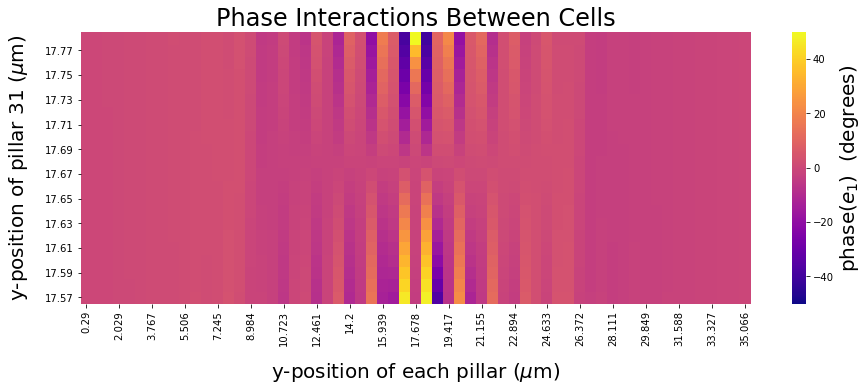

In [48]:
x = pd.DataFrame(XXX*1e9, columns = ['Pillar Positions'])
y = pd.DataFrame(np.round(ypos*1e3, 3), columns = ['ypos'])
#z = pd.DataFrame(E1P, columns = ['phase$(e1_1)$', 'phase$(e1_2)$', 'phase$(e1_3)$', 'phase$(e1_4)$', 
 #                                                       'phase$(e1_5)$', 'phase$(e1_6)$', 'phase$(e1_7)$', 'phase$(e1_8)$',
  #                                                      'phase$(e1_9)$', 'phase$(e1_{10})$'])

#df = pd.concat((pd.concat((x, y), axis=1), z), axis=1)
#df2 = df.pivot(index="ypos", columns="Rx", values="phase(e1)")
#df2
df3 = pd.DataFrame(E1P, columns=np.round(XXX*1e6, 3), index=np.round(ypos/1e3, 3))


ax = sns.heatmap(df3, cmap='plasma', cbar_kws={'label': 'phase($e_1$)  (degrees)'}, vmin=-50, vmax=50)
ax.invert_yaxis()
ax.set_xlabel('y-position of each pillar ($\mu$m)', labelpad=15, fontsize=20)
ax.set_ylabel('y-position of pillar 31 ($\mu$m)', labelpad=15, fontsize=20)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.set_title('Phase Interactions Between Cells', fontsize=24)



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5, forward=True)

In [49]:
YYY = df3.iloc[-1] - df3.iloc[0] 

In [50]:
ZZZ = XXX*1e6

In [51]:
Y = (YYY.iloc[15:45])

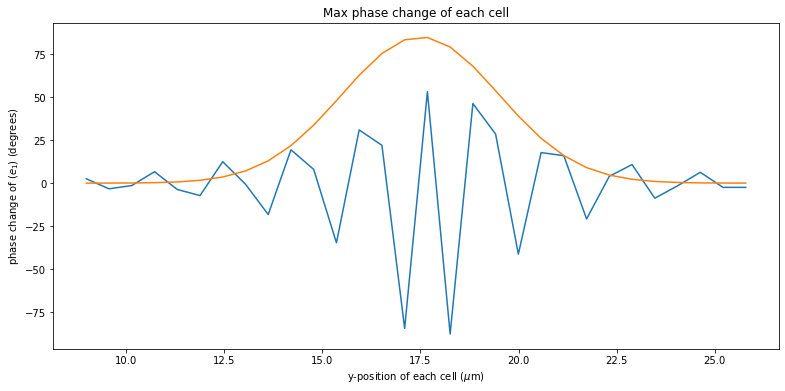

In [52]:
plt.plot(ZZZ[15:45], Y)
plt.plot(ZZZ[15:45], 85*np.exp(-(ZZZ[15:45]-17.5)**2/(2*2**2)))
plt.xlabel('y-position of each cell ($\mu$m)')
plt.ylabel('phase change of ($e_1$) (degrees)')
plt.title('Max phase change of each cell')
fig = matplotlib.pyplot.gcf()

fig.set_size_inches(13, 6, forward=True)

funcion coefficients:
[67.25700732 17.87217101  1.8312202 ]
Covariance of coefficients:
[[ 4.81043072e+01 -4.89210762e-02 -8.69768944e-01]
 [-4.89210762e-02  3.52887292e-02  8.74616188e-04]
 [-8.69768944e-01  8.74616188e-04  3.91260948e-02]]


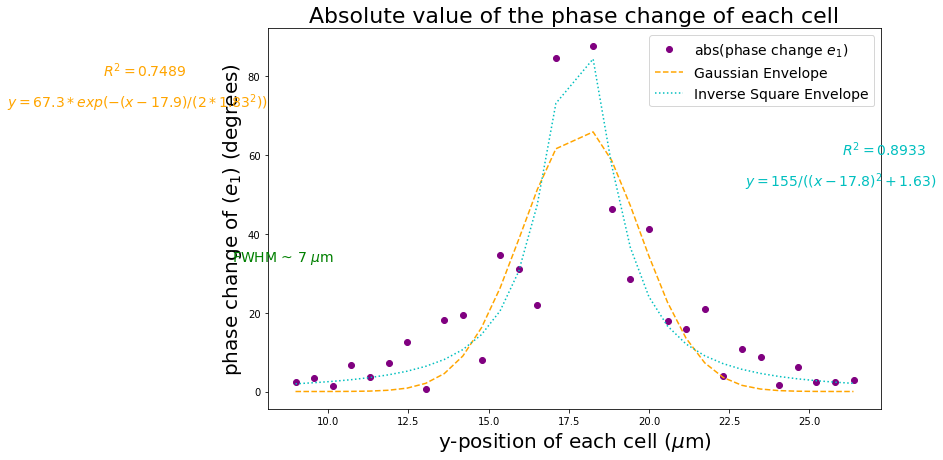

In [62]:
x = ZZZ
x = np.delete(x, 30)
y = np.abs(np.array(YYY))
y = np.delete(y, 30)


def model_gauss(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))
  
param, param_cov = curve_fit(model_gauss, x, y, p0=np.array([90, 18, 2])) 
  
print("funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

residuals = y-model_gauss(x, param[0], param[1], param[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
#print(r_squared)

ans =  param[0]*np.exp(-(x-param[1])**2/(2*param[2]**2))


#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#print('S = ', slope, 'intercept = ', intercept, 'r^2 = ',  r_value**2, 'error = ', std_err)

plt.plot(x, y, 'o', label='abs(phase change $e_1$)', color='purple')
plt.plot(x, ans, label='Gaussian Envelope', ls='--', color='orange')
plt.plot(x, 155/((x-17.8)**2+1.63), label='Inverse Square Envelope', ls=':', color='c' )

plt.title('Absolute value of the phase change of each cell', fontsize=22)
plt.xlabel('y-position of each cell ($\mu$m)', fontsize=20)
plt.ylabel('phase change of ($e_1$) (degrees)', fontsize=20)

plt.legend(loc='upper right', fontsize=14)
plt.text(3, 80, '$R^2=${r:.4f}'.format(r = r_squared), fontsize=14, color='orange')
plt.text(0, 72, '$y = 67.3*exp(-(x-17.9)/(2*1.83^2))$', fontsize=14, color='orange')

plt.text(26, 60, '$R^2=0.8933$', fontsize=14, color='c')
plt.text(23, 52, '$y = 155/((x-17.8)^2+1.63$)', fontsize=14, color='c')

plt.text(7, 33, 'FWHM ~ 7 $\mu$m', fontsize=14, color='g')



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 7, forward=True)

funcion coefficients:
[ 7.19290737e-01  1.78870616e-05 -1.91192589e-06]
Covariance of coefficients:
[[ 4.52739837e-03  4.08619721e-16  8.02342872e-09]
 [ 4.08619721e-16  4.26571937e-14 -9.00148457e-22]
 [ 8.02342872e-09 -9.00148457e-22  4.26572090e-14]]
0.761402025338069


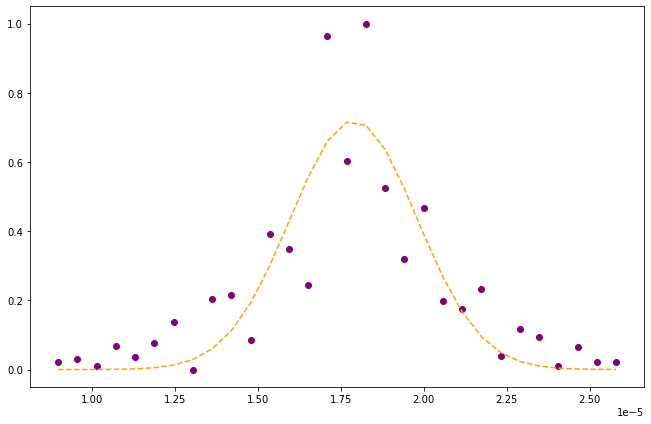

In [66]:
x = ZZZ/1e6
y = np.abs(np.array(YYY))
x2 = x[15:45]
y2 = y[15:45]
x = x2.copy()
y = NormalizeData(y2)

def model_gauss(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))
  
param, param_cov = curve_fit(model_gauss, x, y) 
  
print("funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

residuals = y-model_gauss(x, param[0], param[1], param[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

ans =  param[0]*np.exp(-(x-param[1])**2/(2*param[2]**2))


#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#print('S = ', slope, 'intercept = ', intercept, 'r^2 = ',  r_value**2, 'error = ', std_err)

plt.plot(x, y, 'o', label='abs(phase change $e_1$)', color='purple')
plt.plot(x, ans, label='Gaussian Envelope', ls='--', color='orange')
#plt.plot(x, 155/((x-17.8)**2+1.63), label='Inverse Square Envelope', ls=':', color='c' )



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 7, forward=True)

funcion coefficients:
[155.39857533  17.79679476   1.63586715]
Covariance of coefficients:
[[3.42069090e+02 1.01583017e-01 4.89396934e+00]
 [1.01583017e-01 3.91454166e-03 2.19003965e-03]
 [4.89396934e+00 2.19003965e-03 7.90089466e-02]]


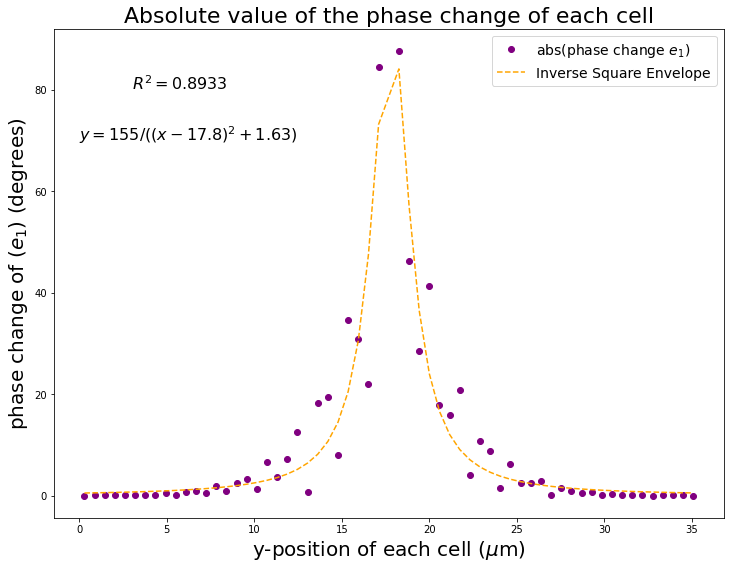

In [170]:
x = ZZZ
x = np.delete(x, 30)
y = np.abs(np.array(YYY))
y = np.delete(y, 30)

def model_gauss(x, a, b, c):
    return a/((x-b)**2+c)
  
param, param_cov = curve_fit(model_gauss, x, y, p0=np.array([1, 1, 1])) 
  
print("funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

residuals = y-model_gauss(x, param[0], param[1], param[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
ans =  param[0]/((x-param[1])**2+param[2])


#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#print('S = ', slope, 'intercept = ', intercept, 'r^2 = ',  r_value**2, 'error = ', std_err)

plt.plot(x, y, 'o', label='abs(phase change $e_1$)', color='purple')
plt.plot(x, ans, label='Inverse Square Envelope', ls='--', color='orange')

plt.title('Absolute value of the phase change of each cell', fontsize=22)
plt.xlabel('y-position of each cell ($\mu$m)', fontsize=20)
plt.ylabel('phase change of ($e_1$) (degrees)', fontsize=20)

plt.legend(loc='upper right', fontsize=14)
plt.text(3, 80, '$R^2=${r:.4f}'.format(r = r_squared), fontsize=16)
plt.text(0, 70, '$y = 155/((x-17.8)^2+1.63$)', fontsize=16)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 9, forward=True)

funcion coefficients:
[43.65161904 17.98185694  2.19096917]
Covariance of coefficients:
[[ 2.47107885e+01 -1.54349527e-02 -8.69035504e-01]
 [-1.54349527e-02  7.24162513e-02 -7.20958777e-04]
 [-8.69035504e-01 -7.20958777e-04  8.13134246e-02]]


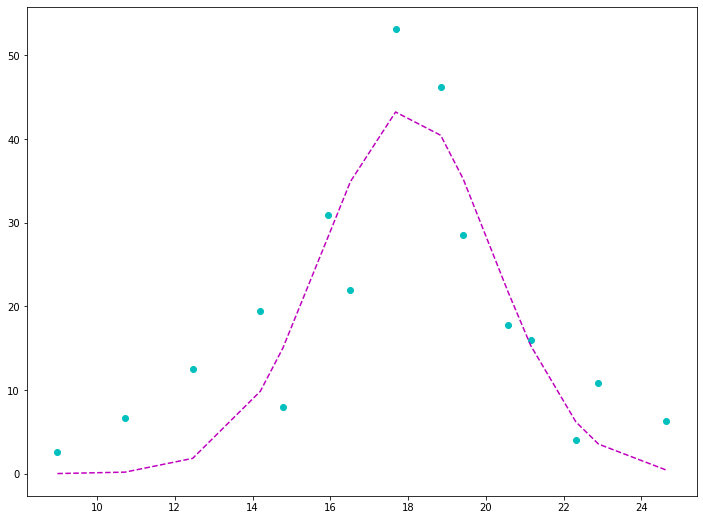

In [128]:
npy = np.array(Y)
x = np.array(ZZZ[15:45])
x = x[np.where(npy > 0)]
y = npy[np.where(npy > 0)]

def model_gauss(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))
  
param, param_cov = curve_fit(model_gauss, x, y, p0=np.array([90, 18, 2])) 
  
print("funcion coefficients:") 
print(param) 
print("Covariance of coefficients:") 
print(param_cov) 

residuals = y-model_gauss(x, param[0], param[1], param[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
#print(r_squared)


  
# ans stores the new y-data according to  
# the coefficients given by curve-fit() function 
#ans = param[0]*x**3+param[1]*x**2 +param[2]*x +param[3]
ans =  param[0]*np.exp(-(x-param[1])**2/(2*param[2]**2))


#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#print('S = ', slope, 'intercept = ', intercept, 'r^2 = ',  r_value**2, 'error = ', std_err)


plt.plot(x, y, 'o', label='max($e_1$)', color='c')
plt.plot(x, ans, label='Fitted Sigmoid', color='m', ls='--')

#plt.title('Maximum Possible $e_1$ at Various Energies', fontsize=22)
#plt.xlabel('Relative Velocity (beta)', fontsize=20)
#plt.ylabel('Maximum $e_1$ Value', fontsize=20)

#plt.legend(loc='lower right', fontsize=14)
#plt.text(0.21, 0.75, '$R^2=${r:.4f}'.format(r = r_squared), fontsize=16)
#plt.text(0.21, 0.825, '$y = 0.17 + 0.72/(1+exp(-15.9(x-0.48)))$', fontsize=16)


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 9, forward=True)

In [14]:
npy = np.array(Y)
np.sum(npy[np.where(npy > 0)]) - np.abs(np.sum(npy[np.where(npy < 0)]))

-33.84999999999991

In [60]:
A = np.linspace(1, 30, 30)
B = 1/(A-15)**2
C = np.exp(-(A-15)**2/(2*2**2))

<ipython-input-60-b065cdb9aac9>:2: RuntimeWarning: divide by zero encountered in true_divide
  B = 1/(A-15)**2


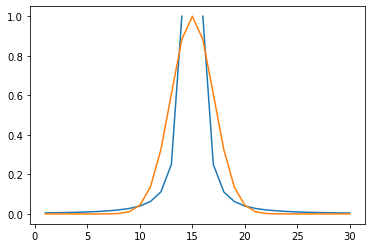

In [61]:
plt.plot(A, B)
plt.plot(A, C)

In [62]:
np.array(np.loadtxt("retvalarray_nonperiodic-ramp.txt"))

array([6.27973940e-02, 6.72249322e-02, 9.26410036e-02, 1.81877923e-01,
       2.35167670e-01, 3.12850407e-01, 9.26438151e-01, 1.70337744e-02,
       4.72462657e-01, 1.15457197e+00, 4.88556349e-02, 1.66805841e-03,
       8.60039508e-01, 2.97197572e-02, 3.60997561e-02, 7.03442426e-05])

In [ ]:
NPbasinarray = np.array(np.loadtxt("basinarray_singlepillar-superposition.txt"))

In [ ]:
optresult = np.array(np.loadtxt("optimizedresult-singlepillar-1.txt"))

In [ ]:
NP_e1_array = np.array(np.loadtxt("e1_array_030.txt"))
NPRARR = np.array(np.loadtxt("R_array_030.txt"))

In [ ]:
NP_e1_array[np.argmax(NP_e1_array)], NPRARR[np.argmax(NP_e1_array)]

In [ ]:
NPRARR[60:380]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(NP_e1_array)
dfR = pd.DataFrame(NPRARR, columns=['Rx', 'Ry', 'ypos'])

In [ ]:
dfR = dfR[(dfR.Ry <= 250e-9) & (dfR.Ry >= 100e-9)]

In [ ]:
dfR = dfR[(dfR.Rx <= 250e-9) & (dfR.Rx >= 100e-9)]

In [ ]:
df2 = dfR.drop(dfR[(dfR.Ry > 250e-9) & (dfR.Ry < 100e-9)].index)

In [ ]:
df2 = df.loc[dfR.index]

In [ ]:
df2.max(), df2.idxmax()

In [ ]:
dfR.loc[70]

In [ ]:
best_Gn

In [ ]:
optresult

In [ ]:
best_Gn

In [ ]:
optresult, minret, best_Gn = adam_optimize(func, rguess1, bnds, step_size=10.0e-9, Nsteps=5, direction='max')

In [ ]:
paramrange = np.array([16, 18, 20, 22])

In [ ]:
##### run accel calc with e[-1] and max_Periods_array then find 40.88+np.sum(dW)=total energy 

In [ ]:
np.random.choice(paramrange, 4, replace=False)


In [ ]:
basinarray = []
retvalarray = []
best_fit_array = []
paramrange = np.array([16, 18, 20, 22])
# ten random starting points each optimized to local minima or maxiter
for y in range(4):
    for z in range(4):
        Adjoint_phase = 0.0
        lockin = 15
        lockin_prev = 15
        rguess1 = np.full((Periods, 3), [paramrange[y]*10e-9, paramrange[z]*10e-9, lmp/2])
        for j in range(Periods):
            rguess1[j][2] = (0.5*max_Periods_array[j])+np.sum(max_Periods_array[:j])
        rguess1 = rguess1.flatten()
        #force minimum step size to 1nm 
        param_basin, maxretval, best_fit = adam_optimize(func, rguess1, bnds, step_size=100.0e-9, Nsteps=4, direction='max')
        basinarray.append(param_basin)
        retvalarray.append(maxretval)
        best_fit_array.append(best_fit)
        NPbasinarray = np.array(basinarray)
        NPretvalarray = np.array(retvalarray)
        NPbest_fit_array = np.array(best_fit_array)
        np.savetxt("basinarray_singlepillar-superposition.txt", np.array(NPbasinarray))
        np.savetxt("retvalarray_singlepillar-superposition.txt", np.array(NPretvalarray))
        np.savetxt("best_fit_array-singlepillar.txt", np.array(NPbest_fit_array))
        #save params and maxvalue 

In [ ]:
np.savetxt("optimizedresult-singlepillar-1.txt", np.array(optresult))

In [ ]:
NPbasinarray = np.array(basinarray)
NPretvalarray = np.array(retvalarray)
NPbest_fit_array = np.array(best_fit_array)
np.savetxt("basinarray_nonperiodic-17.txt", np.array(NPbasinarray))
np.savetxt("retvalarray_nonperiodic-17.txt", np.array(NPretvalarray))
np.savetxt("best_fit_array-17.txt", np.array(NPbest_fit_array))

In [ ]:
np.savetxt("basinarray_nonperiodic-17.txt", np.array(NPbasinarray))
np.savetxt("retvalarray_nonperiodic-17.txt", np.array(NPretvalarray))
np.savetxt("best_fit_array-17.txt", np.array(NPbest_fit_array))
best_fit_array

In [ ]:
NPretvalarray

In [ ]:
max_Periods_array[-1]/max_Periods_array[0]

In [ ]:
idx = np.argmin(NPretvalarray)
Ropt = NPbasinarray[idx]
idx

In [ ]:
H = 15

In [ ]:
e = np.array(np.loadtxt("non-periodic-superposition.txt"))

In [ ]:
e = e[:, H:Periods-H]

In [ ]:
e.shape

In [ ]:
e = e[:2]

In [ ]:
%matplotlib notebook

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation
fig, ax = plt.subplots()

line, = ax.plot([])

XX = np.reshape(rguess1, (Periods, number_of_params))[:,2]
XX = XX[H:Periods-H]

plt.plot(XX, d_n[H:Periods-H], 'o')
def animate_func(num):
    plt.plot(XX, e[num],)
    #plt.ylim((0.0, 0.30))
line_ani = animation.FuncAnimation(fig, animate_func, interval=500)
plt.show()

In [ ]:
A = np.reshape(rguess1, (Periods, number_of_params))[:,2]

In [ ]:
plt.plot(B[8:52], best_Gn[8:52])
plt.plot(B[8:52], d_n[8:52], 'o')

In [ ]:
#beta    e1
#0.4 -> 0.31

In [ ]:
np.savetxt("Final-superposition-bestGvals-150per-1.txt", np.array(best_Gn))

In [ ]:
H = 10

In [ ]:
XX = np.reshape(rguess1, (Periods, number_of_params))[:,2]
XX = np.linspace(0, Periods, Periods)
XX = XX[H:Periods-H]

plt.plot(XX, d_n[H:Periods-H], 'o')
#plt.plot(XX, best_Gn[H:Periods-H])